# Feedforward Neural Network (Multilayer Perceptron - MLP)
Нейронная сеть с прямолинейным движением (многослойный перцептрон - MLP)

# 1. Импорт библиотек
Этот блок содержит все необходимые импорты библиотек для:

- Работы с данными (numpy, pandas)
- Машинного обучения (tensorflow, sklearn)
- Обработки сигналов (pywt для вейвлет-преобразований)
- Визуализации (seaborn, matplotlib)

# 1. Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import ast
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")


# 2. Загрузка данных
Читаем CSV-файл с данными.
df.head(6) выводит первые 6 строк таблицы

In [4]:
df = pd.read_csv('final_dataset.csv')  # Убедитесь, что путь к файлу указан правильно
df.head(6)

,Clean_Signal,Noisy_Signal,Class
0,-0.050548,0.120108,0
1,-0.022422,-0.007673,0
2,0.430269,1.163845,1
3,0.101930,0.100857,0
4,1.462921,2.911377,1
5,0.045052,0.629904,1


# 3. Функции для извлечения признаков из сигнала
️ Функция для временных, частотных и вейвлет-признаков
- Вычисляются основные статистические характеристики сигнала (среднее, медиана, энтропия, перекрестные нули и т. д.).
- Метод Вельча (welch) используется для оценки спектра мощности сигнала.
- Вычисляются такие показатели, как спектральная энергия, спектральный центроид и энтропия спектра
- Вейвлет-преобразование (pywt.wavedec) анализирует сигналы на разных масштабах.
Это позволяет выявить закономерности, которые трудно обнаружить в исходном сигнале.

In [6]:
def extract_enhanced_features(signal, fs=1000):
    """Extração de características temporais, frequenciais e wavelet"""
    features = {}

    # 1. Características estatísticas básicas
    features.update({
        'mean': np.mean(signal),
        'std': np.std(signal),
        'max': np.max(signal),
        'min': np.min(signal),
        'median': np.median(signal),
        'q25': np.percentile(signal, 25),
        'q75': np.percentile(signal, 75),
        'rms': np.sqrt(np.mean(signal**2)),
        'zero_crossings': ((signal[:-1] * signal[1:]) < 0).sum(),
        'entropy': np.sum(-signal * np.log(signal + 1e-10)),
        'skewness': pd.Series(signal).skew(),
        'kurtosis': pd.Series(signal).kurtosis()
    })

    # 2. Características frequenciais (método de Welch)
    try:
        f, Pxx = welch(signal, fs=fs, nperseg=min(len(signal), 256))
        features.update({
            'spectral_centroid': np.sum(f * Pxx) / np.sum(Pxx),
            'spectral_bandwidth': np.sqrt(np.sum((f - features['spectral_centroid'])**2 * Pxx)),
            'spectral_entropy': -np.sum(Pxx * np.log2(Pxx + 1e-12)),
            'spectral_flatness': np.exp(np.mean(np.log(Pxx + 1e-10))) / np.mean(Pxx),
            'spectral_energy': np.sum(Pxx),
            'peak_frequency': f[np.argmax(Pxx)]
        })
    except:
        features.update({k: 0 for k in ['spectral_centroid', 'spectral_bandwidth',
                                      'spectral_entropy', 'spectral_flatness',
                                      'spectral_energy', 'peak_frequency']})

    # 3. Características wavelet
    try:
        coeffs = pywt.wavedec(signal, 'db4', level=3)
        for i, c in enumerate(coeffs):
            features.update({
                f'wavelet_l{i}_mean': np.mean(c),
                f'wavelet_l{i}_std': np.std(c),
                f'wavelet_l{i}_energy': np.sum(c**2),
                f'wavelet_l{i}_entropy': -np.sum(c**2 * np.log(c**2 + 1e-10))
            })
        total_energy = np.sum([np.sum(c**2) for c in coeffs])
        features.update({
            'wavelet_total_energy': total_energy,
            'wavelet_energy_ratio': np.sum(coeffs[0]**2) / (total_energy + 1e-10)
        })
    except:
        wavelet_features = {f'wavelet_l{i}_{j}': 0 for i in range(4)
                          for j in ['mean', 'std', 'energy', 'entropy']}
        wavelet_features.update({
            'wavelet_total_energy': 0,
            'wavelet_energy_ratio': 0
        })
        features.update(wavelet_features)

    return features

def extract_spectrogram_features(signal, fs=1000):
    """Extração de características da espectrograma do sinal"""
    features = {}

    try:
        f, t, Sxx = spectrogram(signal, fs=fs, nperseg=256)

        # Espectro centroids
        spectral_centroid = np.sum(f[:, None] * Sxx, axis=0) / np.sum(Sxx, axis=0)
        features.update({
            'spec_centroid_mean': np.mean(spectral_centroid),
            'spec_centroid_std': np.std(spectral_centroid),
            'spec_centroid_max': np.max(spectral_centroid),
            'spec_centroid_min': np.min(spectral_centroid)
        })

        # Largura espectral
        spectral_bandwidth = np.sqrt(np.sum((f[:, None] - spectral_centroid)**2 * Sxx, axis=0) / np.sum(Sxx, axis=0))
        features.update({
            'spec_bandwidth_mean': np.mean(spectral_bandwidth),
            'spec_bandwidth_std': np.std(spectral_bandwidth)
        })

        # Entropia espectral
        spectral_entropy = -np.sum(Sxx * np.log(Sxx + 1e-10), axis=0)
        features.update({
            'spec_entropy_mean': np.mean(spectral_entropy),
            'spec_entropy_std': np.std(spectral_entropy)
        })

        # Planície espectral
        spectral_flatness = np.exp(np.mean(np.log(Sxx + 1e-10), axis=0)) / np.mean(Sxx, axis=0)
        features.update({
            'spec_flatness_mean': np.mean(spectral_flatness),
            'spec_flatness_std': np.std(spectral_flatness)
        })

        # Energia espectral
        spectral_energy = np.sum(Sxx, axis=0)
        features.update({
            'spec_energy_mean': np.mean(spectral_energy),
            'spec_energy_std': np.std(spectral_energy),
            'spec_total_energy': np.sum(Sxx),
            'spec_peak_freq': f[np.argmax(np.mean(Sxx, axis=1))]  # Pico da frequência
        })
    except:
        spec_features = {
            'spec_centroid_mean': 0, 'spec_centroid_std': 0,
            'spec_centroid_max': 0, 'spec_centroid_min': 0,
            'spec_bandwidth_mean': 0, 'spec_bandwidth_std': 0,
            'spec_entropy_mean': 0, 'spec_entropy_std': 0,
            'spec_flatness_mean': 0, 'spec_flatness_std': 0,
            'spec_energy_mean': 0, 'spec_energy_std': 0,
            'spec_total_energy': 0, 'spec_peak_freq': 0
        }
        features.update(spec_features)

    return features

def extract_all_features(signal, fs=1000):
    """Extração de todas as características (temporais, frequenciais, espectrais e wavelet)"""
    signal = ensure_signal_is_sequence(signal)  # Garantir que o sinal seja uma sequência de números
    features = {}
    features.update(extract_enhanced_features(signal, fs))
    features.update(extract_spectrogram_features(signal, fs))
    return features

# 4. Комбинированная функция извлечения признаков
Объединяет все признаки из предыдущих функций в один словарь.

In [7]:

def extract_all_features(signal, fs=1000):
    """Extração de todas as características (temporais, frequenciais, espectrais e wavelet)"""
    signal = ensure_signal_is_sequence(signal)  # Garantir que o sinal seja uma sequência de números
    features = {}
    features.update(extract_enhanced_features(signal, fs))
    features.update(extract_spectrogram_features(signal, fs))
    return features

# Função para garantir que o sinal seja uma sequência de números (array ou lista)
def ensure_signal_is_sequence(signal):
    if isinstance(signal, str):  # Se for uma string, tenta convertê-la
        try:
            signal = np.array(ast.literal_eval(signal))
        except:
            signal = np.zeros(100)  # Em caso de falha, cria um array de zeros
    elif isinstance(signal, (float, int)):  # Se for um único valor, cria um array
        signal = np.array([signal])
    elif not isinstance(signal, np.ndarray):  # Se não for array, converte para array
        signal = np.array(signal)
    return signal

# 5. Подготовка данных
- Извлекаются признаки для чистых (Clean_Signal) и зашумленных (Noisy_Signal) сигналов.
- Объединяются в матрицу признаков X.
- Целевая переменная y — это столбец Class.
- Обрабатываются NaN и бесконечные значения.

In [8]:
# Aplicando as funções para extração de características no DataFrame
print("Извлечение характеристик из сигналов...")
clean_features = pd.DataFrame(df['Clean_Signal'].apply(lambda x: extract_all_features(x, fs=1000)).tolist()).add_prefix('clean_')
noisy_features = pd.DataFrame(df['Noisy_Signal'].apply(lambda x: extract_all_features(x, fs=1000)).tolist()).add_prefix('noise_')

# Combina todas as características
X = pd.concat([clean_features, noisy_features,
               df[['Clean_Signal', 'Noisy_Signal']]], axis=1)
y = df['Class']

# Tratar valores NaN/inf
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)



Извлечение характеристик из сигналов...


# 6. Разделение данных и SMOTE
Данные делятся на обучающую и тестовую выборки (80/20). SMOTE используется для устранения дисбаланса классов в обучающих данных.

In [10]:
# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicando SMOTE manualmente no treino
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 7. Обучение нейросети (MLP)
- Используется MLP (многослойный перцептрон).
- Dropout(0.3) помогает избежать переобучения.
- Регуляризация L2 также помогает улучшить генерализацию модели.

In [13]:
# Definindo o modelo MLP com TensorFlow
model = Sequential([
    Dense(128, input_dim=X_train_res.shape[1], activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Regularização L2
    Dropout(0.3),  # Aumento do Dropout
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Regularização L2
    Dropout(0.3),  # Aumento do Dropout
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Regularização L2
    Dense(1, activation='sigmoid')
])

# Compilando o modelo com uma taxa de aprendizado adaptativa
optimizer = Adam(learning_rate=0.001)  # Taxa de aprendizado ajustada
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping para evitar overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

print("\nAрхитектура модели с количеством параметров:")
model.summary()


Aрхитектура модели с количеством параметров:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 128)                 │          13,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,553 (92.00 KB)

 Trainable params: 23,553 (92.00 KB)

 Non-trainable params: 0 (0.00 B)

# 8. Обучение модели
Обучение модели с:
Ранней остановкой для предотвращения переобучения
Разделением на обучение и валидацию
30 эпохами (но может остановиться раньше из-за EarlyStopping)

In [14]:
# Treinando o modelo
history = model.fit(X_train_res, y_train_res, epochs=30, batch_size=32, validation_split=0.2, verbose=2, callbacks=[early_stopping])

# Predição no conjunto de teste
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

Epoch 1/30
23/23 - 3s - 150ms/step - accuracy: 0.8030 - loss: 2.7087 - val_accuracy: 0.9399 - val_loss: 2.2428
Epoch 2/30
23/23 - 0s - 11ms/step - accuracy: 0.9480 - loss: 1.9545 - val_accuracy: 0.9617 - val_loss: 1.6303
Epoch 3/30
23/23 - 0s - 10ms/step - accuracy: 0.9508 - loss: 1.4244 - val_accuracy: 0.9563 - val_loss: 1.1845
Epoch 4/30
23/23 - 0s - 10ms/step - accuracy: 0.9453 - loss: 1.0433 - val_accuracy: 0.9563 - val_loss: 0.8896
Epoch 5/30
23/23 - 0s - 10ms/step - accuracy: 0.9508 - loss: 0.7943 - val_accuracy: 0.9617 - val_loss: 0.6974
Epoch 6/30
23/23 - 0s - 10ms/step - accuracy: 0.9549 - loss: 0.6304 - val_accuracy: 0.9617 - val_loss: 0.5669
Epoch 7/30
23/23 - 0s - 10ms/step - accuracy: 0.9603 - loss: 0.5168 - val_accuracy: 0.9617 - val_loss: 0.4777
Epoch 8/30
23/23 - 0s - 10ms/step - accuracy: 0.9576 - loss: 0.4363 - val_accuracy: 0.9617 - val_loss: 0.4123
Epoch 9/30
23/23 - 0s - 10ms/step - accuracy: 0.9576 - loss: 0.3837 - val_accuracy: 0.9617 - val_loss: 0.3689
Epoch 10/

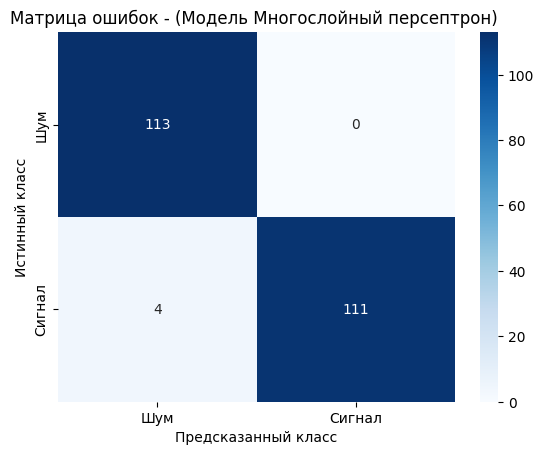

In [16]:
# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Шум', 'Сигнал'], yticklabels=['Шум', 'Сигнал'])
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок - (Модель Многослойный персептрон) ')
plt.show()

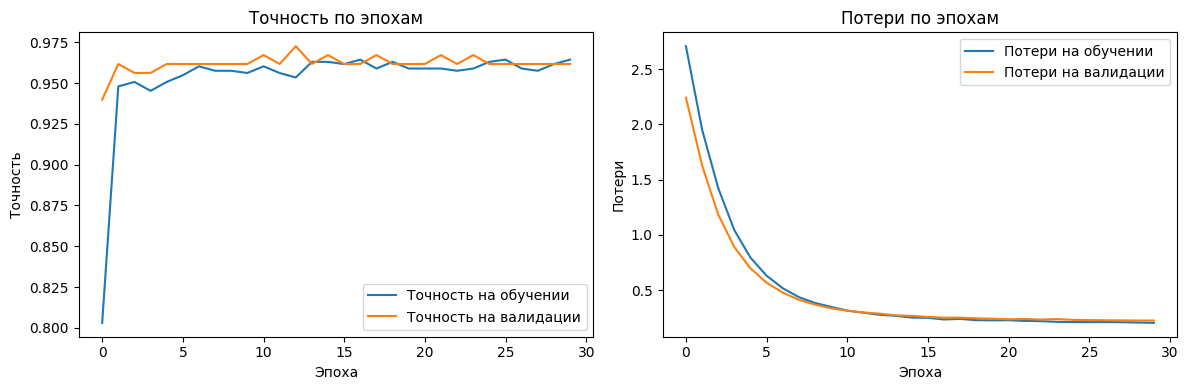

In [17]:
plt.figure(figsize=(12, 4))
    
plt.subplot(1, 2, 1)  
plt.plot(history.history['accuracy'], label='Точность на обучении')  
plt.plot(history.history['val_accuracy'], label='Точность на валидации')  
plt.title('Точность по эпохам')  
plt.xlabel('Эпоха')  
plt.ylabel('Точность')  
plt.legend()  
  
plt.subplot(1, 2, 2)  
plt.plot(history.history['loss'], label='Потери на обучении')  
plt.plot(history.history['val_loss'], label='Потери на валидации')  
plt.title('Потери по эпохам')  
plt.xlabel('Эпоха')  
plt.ylabel('Потери')  
plt.legend()  
  
plt.tight_layout()  
plt.show() 